Focus this notebook on evaluation of coherence of topics in learned models.

### Import packages

In [2]:
import os
import glob
import zipfile
import shutil
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
import scipy.stats as stats
import datetime
import pylab as pl
import math
import codecs
import nltk
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import time
import json
import gensim
from gensim import corpora, models
from gensim.matutils import hellinger
from gensim.models.coherencemodel import CoherenceModel
import logging
%matplotlib inline

### Set all important file paths

In [3]:
pwd()

u'/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project'

In [8]:
# Richard path specs

# # At work:
# TEXT_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/Text/"
# PDF_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/PDF/"
# LIBRARY_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/Libraries/"

# # At home:
# dict_path = '/Users/Richard/Desktop/Berkeley/w266/'
# input_path = '/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/'
# output_path = '/Users/Richard/Desktop/Berkeley/w266/'

# LIBRARY_PATH = '/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/'



In [4]:
# Tom path specs

# Tom machine:
TEXT_DIR_LIST = ["T1", "T2", "T3", "T4"]
# PDF_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/PDF/"
LIBRARY_PATH = "/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/"

# On Tom's google cloud instance
# LIBRARY_PATH = "/home/seddon/w266_project/"



In [5]:
class Saved_state():
    '''Represents a saved state that includes an LDA model and the data used to create it.
    
       Instantiated with a model_spec dictionary that locates the files to 
       recreate the saved state and includes a description.
       
       Dictionary needs to contain:
       
       model_files
       qa_pairs_file
       raw_qa_text_file
       corpus_file
       hellinger_file
       '''
    def __init__(self, model_spec):
        
        model_dir = LIBRARY_PATH+model_spec["model_directory"]
        qa_dir = LIBRARY_PATH+model_spec["qa_pair_directory"]
        
        self.ldamodel = gensim.models.ldamodel.LdaModel.load(model_dir+"/full_model")
        
        self.dictionary = gensim.corpora.dictionary.Dictionary.load(model_dir+"/dictionary.txt")
        
        with open(qa_dir+"/qa_pairs.txt", "r") as f:
            self.qa_pairs = json.loads(f.read())
            
        with open(LIBRARY_PATH + "/raw_qa_data.txt", "r") as f:
            self.raw_qa_text = json.loads(f.read())
            
        with open(model_dir+"/corpus.txt", "r") as f:
            self.corpus = json.loads(f.read())
            
        with open(model_dir+"/hell_sims.txt", "r") as f:
            self.hellinger_sims = json.loads(f.read())
            
        with open(model_dir+"/model_runtime.txt", "r") as f:
            self.model_runtime = f.read()

In [6]:
def get_coherences(model_spec, topn_list):
    '''Retrieves saved model from a model spec.  Returns a dict containing
       top n words, membership in topic per word and u_mass coherence
       measures for these top n words.'''
    
    coherences = dict()
    
    saved = Saved_state(model_spec)

    ldamodel = saved.ldamodel
    corpus = saved.corpus
    dictionary = saved.dictionary

    for n in topn_list:

        cm = CoherenceModel(model = ldamodel, corpus = corpus, coherence = "u_mass", topn = n)
        
#         coherences[n] = cm.get_coherence_per_topic()
        
        coherences[n] = ldamodel.top_topics(corpus = corpus, coherence = "u_mass", topn = n)
        
    return coherences

In [12]:
# model_spec_list = [{"model_directory": "saved_models/topic20_minlength20_base",
#               "qa_pair_directory": "saved_models/standard_preproc",
#               "preprocessing_function": "testLDA_pre_process_document",
#               "min_sequence_length": 20,
#               "num_topics": 20,
#               "description": "test model"}]

model_dir_list = ["top10_len10_prebase_ps20_it100", "top10_len20_prebase_ps20_it100",
                  "top10_len40_prebase_ps20_it100", "top20_len10_prebase_ps20_it100",
                  "top20_len20_prebase_ps20_it100", "top20_len40_prebase_ps20_it100",
                  "top40_len10_prebase_ps20_it100", "top40_len20_prebase_ps20_it100",
                  "top40_len40_prebase_ps20_it100"]

topn_list = [10, 25, 50]

coherences = dict()

for model_dir in model_dir_list:
    
    with open(LIBRARY_PATH+"saved_models/"+model_dir+"/model_spec.txt") as f:
        model_spec = json.loads(f.read())
    
    start_time = time.time()
    
    print "evaluating coherence measures for", model_spec["description"]
    
    num_topics = model_spec["num_topics"]
    min_sequence_length = model_spec["min_sequence_length"]
    
    coherences[(num_topics, min_sequence_length)] = get_coherences(model_spec, topn_list)
    
    print "evaluation took", time.time() - start_time, "seconds"


# for model_spec in model_spec_list:
    
#     start_time = time.time()
    
#     print "evaluating coherence measures for", model_spec["description"]
    
#     num_topics = model_spec["num_topics"]
#     min_sequence_length = model_spec["min_sequence_length"]
    
#     coherences[(num_topics, min_sequence_length)] = get_coherences(model_spec, topn_list)
    
#     print "evaluation took", time.time() - start_time, "seconds"
    
    

evaluating coherence measures for Topics 10, Min Length 10, base preprocessing, passes20, iterations100
evaluation took 24.0488870144 seconds
evaluating coherence measures for Topics 10, Min Length 20, base preprocessing, passes20, iterations100
evaluation took 28.1455430984 seconds
evaluating coherence measures for Topics 10, Min Length 40, base preprocessing, passes20, iterations100
evaluation took 11.7550959587 seconds
evaluating coherence measures for Topics 20, Min Length 10, base preprocessing, passes20, iterations100
evaluation took 29.2275381088 seconds
evaluating coherence measures for Topics 20, Min Length 20, base preprocessing, passes20, iterations100
evaluation took 25.4610061646 seconds
evaluating coherence measures for Topics 20, Min Length 40, base preprocessing, passes20, iterations100
evaluation took 13.0647530556 seconds
evaluating coherence measures for Topics 40, Min Length 10, base preprocessing, passes20, iterations100
evaluation took 33.4466631413 seconds
evalua

In [27]:
model_dir_list = ["top10_len10_prebase_ps20_it100", "top10_len20_prebase_ps20_it100",
                  "top10_len40_prebase_ps20_it100", "top20_len10_prebase_ps20_it100",
                  "top20_len20_prebase_ps20_it100", "top20_len40_prebase_ps20_it100",
                  "top40_len10_prebase_ps20_it100", "top40_len20_prebase_ps20_it100",
                  "top40_len40_prebase_ps20_it100"]

topn_list = [10, 25, 50]

In [10]:
def evaluate_coherence(model_dir_list, topn_list):

    coherences = dict()

    for model_dir in model_dir_list:

        with open(LIBRARY_PATH+"saved_models/"+model_dir+"/model_spec.txt") as f:
            model_spec = json.loads(f.read())

        start_time = time.time()

        print "evaluating coherence measures for", model_spec["description"]

        num_topics = model_spec["num_topics"]
        min_sequence_length = model_spec["min_sequence_length"]

        coherences[(num_topics, min_sequence_length)] = get_coherences(model_spec, topn_list)

        print "evaluation took", time.time() - start_time, "seconds"
        
    return coherences

In [29]:
model_dir_list = ["top10_len10_prebase_ps20_it100", "top10_len20_prebase_ps20_it100",
                  "top10_len40_prebase_ps20_it100", "top20_len10_prebase_ps20_it100",
                  "top20_len20_prebase_ps20_it100", "top20_len40_prebase_ps20_it100",
                  "top40_len10_prebase_ps20_it100", "top40_len20_prebase_ps20_it100",
                  "top40_len40_prebase_ps20_it100"]

topn_list = [10, 25, 50]

coherences = evaluate_coherence(model_dir_list, topn_list)

evaluating coherence measures for Topics 10, Min Length 10, base preprocessing, passes20, iterations100
evaluation took 25.5652210712 seconds
evaluating coherence measures for Topics 10, Min Length 20, base preprocessing, passes20, iterations100
evaluation took 21.7074668407 seconds
evaluating coherence measures for Topics 10, Min Length 40, base preprocessing, passes20, iterations100
evaluation took 10.7747759819 seconds
evaluating coherence measures for Topics 20, Min Length 10, base preprocessing, passes20, iterations100
evaluation took 28.7826199532 seconds
evaluating coherence measures for Topics 20, Min Length 20, base preprocessing, passes20, iterations100
evaluation took 24.5297939777 seconds
evaluating coherence measures for Topics 20, Min Length 40, base preprocessing, passes20, iterations100
evaluation took 12.7671170235 seconds
evaluating coherence measures for Topics 40, Min Length 10, base preprocessing, passes20, iterations100
evaluation took 32.8372600079 seconds
evalua

In [30]:
coherences

{(10,
  10): {10: [([(0.031972111654476776, u'think'),
     (0.021461197835601419, u'go'),
     (0.014801170351631176, u'busi'),
     (0.013049010927434199, u'us'),
     (0.012179464584258027, u'thing'),
     (0.012101952471837114, u'get'),
     (0.011983201832075093, u'look'),
     (0.011817542195530564, u'realli'),
     (0.011335401859128659, u'make'),
     (0.0097009222031374451, u'time')],
    -1.1979053159202995),
   ([(0.048146401933910829, u'quarter'),
     (0.037542178226369592, u'year'),
     (0.020564448926966655, u'margin'),
     (0.018937107868135857, u'think'),
     (0.017961428023408069, u'growth'),
     (0.0175680244585983, u'see'),
     (0.014218819230860377, u'expect'),
     (0.012867796214145778, u'littl'),
     (0.01283372012430853, u'first'),
     (0.012094381911117091, u'bit')],
    -1.2807560161002862),
   ([(0.19765604860886443, u'NUM'),
     (0.043826416144214397, u'year'),
     (0.017151916391985898, u'think'),
     (0.016295400429183194, u'million'),
     (0.0

## Impact of hyperparameters on the topic quality

Using U_mass coherence as measure of topic quality.  Coherence is measured across a 
certain number of N words in the topic (ranked by the highest probability for that 
word in the topic).

Quality varies by topic.  Can summarize by showing mean and sd of coherence measures.

Showing for 3 different measures of N.

In [7]:
def print_coherence_mean(coherences):
    print "Mean and SD of topic Coherences for learned models"
    print
    print "{:^13}{:^21}{:^21}{:>11}{:>11}{:>11}".format("Num Topics", "Min Seq Length", 
                                                "N words for umass", "Mean", "SD", "SD/Mean")
    print "{:^13}{:^21}{:^21}{:>11}{:>11}{:>11}".format("-"*11, "-"*17, "-"*17, "-"*6, "-"*6, "-"*6)

    for n in [10, 25, 50]:
        print
        for t in sorted(coherences):
            u_mass_scores = [r[1] for r in coherences[t][n]]
            mean_score = np.mean(u_mass_scores)
            sd_score = np.std(u_mass_scores)
            print "{:^13}{:^21}{:^21}{:11.3f}{:11.3f}{:11.3f}".format(t[0], t[1], n, mean_score, sd_score, sd_score/mean_score)


In [33]:
print_coherence_mean(coherences)

Mean and SD of topic Coherences for learned models

 Num Topics     Min Seq Length      N words for umass         Mean         SD    SD/Mean
 -----------   -----------------    -----------------       ------     ------     ------

     10               10                   10               -1.852      0.472     -0.255
     10               20                   10               -1.623      0.517     -0.319
     10               40                   10               -1.452      0.634     -0.436
     20               10                   10               -2.137      0.805     -0.377
     20               20                   10               -2.280      1.607     -0.705
     20               40                   10               -2.404      1.767     -0.735
     40               10                   10               -3.104      1.513     -0.487
     40               20                   10               -2.664      1.105     -0.415
     40               40                   10            

## Evaluating how words in each topic contribute to the total

For each topic, we have a measure of the amount that each word contributes to that topic.

So we can sum up the probabilities across n words in the topic.  The total amount obviously
generally grows as the number of words we are considering grows.  But for the same number 
of N words it gives a sense of how concentrated the topic is in a few words.

In [8]:
def print_word_probs(coherences):
    print "Mean and SD of word probability for n words in learned topics"
    print
    print "{:^13}{:^21}{:^21}{:>11}{:>11}".format("Num Topics", "Min Seq Length", 
                                                "N words for umass", "Mean", "SD")
    print "{:^13}{:^21}{:^21}{:>11}{:>11}".format("-"*11, "-"*17, "-"*17, "-"*6, "-"*6)


    for n in [10, 25, 50]:
        print
        for t in sorted(coherences):
            topic_list = coherences[t][n]
            total_probs = list()    
            for topic_tuple in topic_list:
                word_tuples = topic_tuple[0]
                total_probs.append(sum(w[0] for w in word_tuples))

            mean_prob = np.mean(total_probs)
            sd_prob = np.std(total_probs)

            print "{:^13}{:^21}{:^21}{:11.3f}{:11.3f}".format(t[0], t[1], n, mean_prob, sd_prob)

#         print t, n, np.mean(total_probs), np.std(total_probs)

In [36]:
print_word_probs(coherences)

Mean and SD of word probability for n words in learned topics

 Num Topics     Min Seq Length      N words for umass         Mean         SD
 -----------   -----------------    -----------------       ------     ------

     10               10                   10                0.183      0.071
     10               20                   10                0.183      0.062
     10               40                   10                0.168      0.047
     20               10                   10                0.241      0.075
     20               20                   10                0.262      0.157
     20               40                   10                0.238      0.093
     40               10                   10                0.387      0.156
     40               20                   10                0.382      0.167
     40               40                   10                0.328      0.124

     10               10                   25                0.295      0.086

## Run for the new models with df stopwords

In [37]:
model_dir_list = ["top20_len20_prebase_df5", "top20_len20_prebase_df10",
                  "top20_len20_prebase_df20"]

topn_list = [10, 25, 50]

coherences = evaluate_coherence(model_dir_list, topn_list)

evaluating coherence measures for Topics 20, Min Length 20, base plus df 0.05 threshold
evaluation took 7.6761200428 seconds
evaluating coherence measures for Topics 20, Min Length 20, base plus df 0.10 threshold
evaluation took 14.1594910622 seconds
evaluating coherence measures for Topics 20, Min Length 20, base plus df 0.20 threshold
evaluation took 21.2379159927 seconds


In [38]:
print_coherence_mean(coherences)

Mean and SD of topic Coherences for learned models

 Num Topics     Min Seq Length      N words for umass         Mean         SD    SD/Mean
 -----------   -----------------    -----------------       ------     ------     ------

     20               20                   10               -2.401      0.968     -0.403

     20               20                   25               -2.877      1.611     -0.560

     20               20                   50               -3.456      2.049     -0.593


This has improved coherence n>=25

In [39]:
print_word_probs(coherences)

Mean and SD of word probability for n words in learned topics

 Num Topics     Min Seq Length      N words for umass         Mean         SD
 -----------   -----------------    -----------------       ------     ------

     20               20                   10                0.221      0.127

     20               20                   25                0.335      0.129

     20               20                   50                0.453      0.128


This has reduced word prob a bit but numbers still seem reasonable

## Visualizing for the report

In [26]:
# model_dir_list = ["top10_len10_prebase_ps20_it100", "top10_len20_prebase_ps20_it100",
#                   "top10_len40_prebase_ps20_it100", "top20_len10_prebase_ps20_it100",
#                   "top20_len20_prebase_ps20_it100", "top20_len40_prebase_ps20_it100",
#                   "top40_len10_prebase_ps20_it100", "top40_len20_prebase_ps20_it100",
#                   "top40_len40_prebase_ps20_it100", "1216_top30_len30_prebase", 
#                   "1216_top30_len40_prebase", "1216_top30_len50_prebase",
#                   "1216_top40_len30_prebase",
#                   "1216_top40_len50_prebase", "1216_top50_len30_prebase",
#                   "1216_top50_len40_prebase", "1216_top50_len50_prebase",]

model_dir_list = ["top10_len10_prebase_ps20_it100", "top10_len20_prebase_ps20_it100",
                  "top10_len40_prebase_ps20_it100", "top20_len10_prebase_ps20_it100",
                  "top20_len20_prebase_ps20_it100", "top20_len40_prebase_ps20_it100",
                  "top40_len10_prebase_ps20_it100", "top40_len20_prebase_ps20_it100",
                  "1216_top30_len30_prebase", 
                  "1216_top30_len40_prebase", "1216_top30_len50_prebase",
                  "1216_top40_len30_prebase", "1216_top40_len40_prebase",
                  "1216_top40_len50_prebase", "1216_top50_len30_prebase",
                  "1216_top50_len40_prebase", "1216_top50_len50_prebase",]

topn_list = [10, 25]

coherences = evaluate_coherence(model_dir_list, topn_list)

evaluating coherence measures for Topics 10, Min Length 10, base preprocessing, passes20, iterations100
evaluation took 19.1485290527 seconds
evaluating coherence measures for Topics 10, Min Length 20, base preprocessing, passes20, iterations100
evaluation took 14.9479248524 seconds
evaluating coherence measures for Topics 10, Min Length 40, base preprocessing, passes20, iterations100
evaluation took 10.7732648849 seconds
evaluating coherence measures for Topics 20, Min Length 10, base preprocessing, passes20, iterations100
evaluation took 22.0211129189 seconds
evaluating coherence measures for Topics 20, Min Length 20, base preprocessing, passes20, iterations100
evaluation took 24.9421191216 seconds
evaluating coherence measures for Topics 20, Min Length 40, base preprocessing, passes20, iterations100
evaluation took 12.1500930786 seconds
evaluating coherence measures for Topics 40, Min Length 10, base preprocessing, passes20, iterations100
evaluation took 18.7196228504 seconds
evalua

Create arrays for charting as lines

In [27]:
coherences

{(10,
  10): {10: [([(0.031972111654476776, u'think'),
     (0.021461197835601419, u'go'),
     (0.014801170351631176, u'busi'),
     (0.013049010927434199, u'us'),
     (0.012179464584258027, u'thing'),
     (0.012101952471837114, u'get'),
     (0.011983201832075093, u'look'),
     (0.011817542195530564, u'realli'),
     (0.011335401859128659, u'make'),
     (0.0097009222031374451, u'time')],
    -1.1979053159202995),
   ([(0.048146401933910829, u'quarter'),
     (0.037542178226369592, u'year'),
     (0.020564448926966655, u'margin'),
     (0.018937107868135857, u'think'),
     (0.017961428023408069, u'growth'),
     (0.0175680244585983, u'see'),
     (0.014218819230860377, u'expect'),
     (0.012867796214145778, u'littl'),
     (0.01283372012430853, u'first'),
     (0.012094381911117091, u'bit')],
    -1.2807560161002862),
   ([(0.19765604860886443, u'NUM'),
     (0.043826416144214397, u'year'),
     (0.017151916391985898, u'think'),
     (0.016295400429183194, u'million'),
     (0.0

In [40]:
min_lengths = list()
c_means = dict()

n = 10

for t in sorted(coherences):
    if t[1] not in min_lengths:
        min_lengths.append(t[1])
        
for ml in min_lengths:
    topic_x = []
    mean_u_mass = []
    for t in sorted(coherences):
        if t[1] == ml:
            topic_x.append(t[0])
            topic_list = coherences[t][n]
            mean_u_mass.append(np.mean([topic_tuple[1] for topic_tuple in topic_list]))
    c_means[ml] = (topic_x, mean_u_mass)
            

# for n in [10]:
#     for t in sorted(coherences):
#         if t[1] not in min_lengths:
#             min_lengths.append(t[1])
#         topic_list = coherences[t][n]
#         mean_u_mass[t] = np.mean([topic_tuple[1] for topic_tuple in topic_list])
#         topic_x[t[1]] = t[0]
#         num_topic_dict[t[1]]
#             u_mass = topic_tuple[1]
#             print u_mass
#             total_probs.append(sum(w[0] for w in word_tuples))

#         mean_prob = np.mean(total_probs)
#         sd_prob = np.std(total_probs)

#         print "{:^13}{:^21}{:^21}{:11.3f}{:11.3f}".format(t[0], t[1], n, mean_prob, sd_prob)

In [41]:
c_means

{10: ([10, 20, 40],
  [-1.851535108805161, -2.13721318514117, -3.1036507470345054]),
 20: ([10, 20, 40],
  [-1.6228011842576731, -2.2800912762968166, -2.6640582915174149]),
 30: ([30, 40, 50],
  [-2.436626420564147, -3.1455011389851508, -3.3879456752114332]),
 40: ([10, 20, 30, 40, 50],
  [-1.4523743728411513,
   -2.4037480303704961,
   -2.6190462137801283,
   -2.8310275312252182,
   -3.3230839209593754]),
 50: ([30, 40, 50],
  [-3.3951193123713974, -2.7981828943001639, -3.527278599113798])}

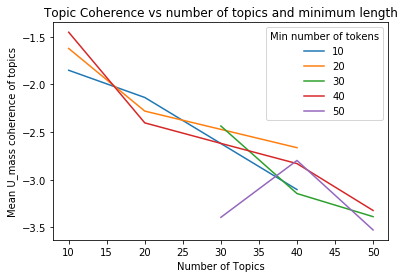

In [48]:
for min_l in sorted(c_means):
    plt.plot(c_means[min_l][0], c_means[min_l][1], label = min_l)
plt.xlabel("Number of Topics")
plt.ylabel("Mean U_mass coherence of topics")
plt.title("Topic Coherence vs number of topics and minimum length")
plt.legend(title = "Min number of tokens")
plt.show()


In [69]:
for c in sorted(coherences):
        print c
        topic_tuples = coherences[c][10]
        highest_topic = topic_tuples[0]
        topic_list = highest_topic[0]
    #     topic_list[0]
        for token_tuple in topic_list:
    #         print word_tuple[1], word_tuple[0]
            print "{:10}{:3.2f}".format(token_tuple[1], token_tuple[0])
        print
    
#     print "U_mass Coherence is ", "{:3.2f}".format(highest_topic[1])
#     print "Top 10 tokens in topic are:"
#     for token_tuple in t[0]:
#         print "{:10}{:3.2f}".format(token_tuple[1], token_tuple[0])

(10, 10)
think     0.03
go        0.02
busi      0.01
us        0.01
thing     0.01
get       0.01
look      0.01
realli    0.01
make      0.01
time      0.01

(10, 20)
think     0.02
busi      0.01
realli    0.01
go        0.01
us        0.01
continu   0.01
look      0.01
product   0.01
make      0.01
well      0.01

(10, 40)
NUM       0.09
year      0.04
quarter   0.03
think     0.01
go        0.01
margin    0.01
expect    0.01
look      0.01
first     0.01
see       0.01

(20, 10)
year      0.04
think     0.04
go        0.03
NUM       0.03
see       0.02
get       0.02
littl     0.01
look      0.01
thing     0.01
time      0.01

(20, 20)
work      0.02
continu   0.02
cost      0.02
product   0.02
us        0.02
make      0.01
go        0.01
realli    0.01
get       0.01
well      0.01

(20, 40)
quarter   0.06
year      0.05
see       0.02
think     0.02
NUM       0.02
first     0.02
last      0.01
expect    0.01
go        0.01
littl     0.01

(30, 30)
custom    0.02
think     0.02
s

In [78]:

for c in sorted(coherences):
    if c == tuple((10, 10)):
        print c
        topic_tuples = coherences[c][10]
        for topic in topic_tuples:
            print "Topics:{:d} MinL:{:d}".format(c[0], c[1])
            print "U_mass: {:3.2f}".format(topic[1])
            topic_list = topic[0]
        #     topic_list[0]
            for token_tuple in topic_list:
        #         print word_tuple[1], word_tuple[0]
                print "{:10}{:3.2f}".format(token_tuple[1], token_tuple[0])
            print

(10, 10)
Topics:10 MinL:10
U_mass: -1.20
think     0.03
go        0.02
busi      0.01
us        0.01
thing     0.01
get       0.01
look      0.01
realli    0.01
make      0.01
time      0.01

Topics:10 MinL:10
U_mass: -1.28
quarter   0.05
year      0.04
margin    0.02
think     0.02
growth    0.02
see       0.02
expect    0.01
littl     0.01
first     0.01
bit       0.01

Topics:10 MinL:10
U_mass: -1.36
NUM       0.20
year      0.04
think     0.02
million   0.02
go        0.02
billion   0.01
number    0.01
look      0.01
point     0.01
get       0.01

Topics:10 MinL:10
U_mass: -1.49
question  0.04
thank     0.04
mayb      0.03
talk      0.02
guess     0.02
okay      0.02
littl     0.02
like      0.02
kind      0.02
bit       0.02

Topics:10 MinL:10
U_mass: -1.89
capit     0.05
cash      0.04
flow      0.03
asset     0.02
return    0.02
balanc    0.01
dividend  0.01
debt      0.01
share     0.01
look      0.01

Topics:10 MinL:10
U_mass: -1.90
market    0.06
price     0.03
see       0.02

In [79]:

for c in sorted(coherences):
    if c == tuple((40, 40)):
        print c
        topic_tuples = coherences[c][10]
        for topic in topic_tuples:
            print "Topics:{:d} MinL:{:d}".format(c[0], c[1])
            print "U_mass: {:3.2f}".format(topic[1])
            topic_list = topic[0]
        #     topic_list[0]
            for token_tuple in topic_list:
        #         print word_tuple[1], word_tuple[0]
                print "{:10}{:3.2f}".format(token_tuple[1], token_tuple[0])
            print

(40, 40)
Topics:40 MinL:40
U_mass: -1.01
think     0.05
go        0.03
thing     0.02
get       0.02
lot       0.02
know      0.02
time      0.01
one       0.01
look      0.01
say       0.01

Topics:40 MinL:40
U_mass: -1.02
term      0.04
think     0.03
go        0.03
NUM       0.03
long      0.02
see       0.02
plan      0.02
time      0.01
get       0.01
year      0.01

Topics:40 MinL:40
U_mass: -1.03
busi      0.02
think     0.02
continu   0.02
go        0.02
invest    0.02
look      0.02
make      0.01
work      0.01
well      0.01
us        0.01

Topics:40 MinL:40
U_mass: -1.18
market    0.06
busi      0.04
growth    0.03
see       0.03
think     0.03
continu   0.02
well      0.02
strong    0.01
look      0.01
perform   0.01

Topics:40 MinL:40
U_mass: -1.20
NUM       0.32
year      0.05
million   0.03
billion   0.02
number    0.01
go        0.01
look      0.01
think     0.01
guidanc   0.01
expect    0.01

Topics:40 MinL:40
U_mass: -1.21
custom    0.05
us        0.02
valu      0.02

## Visualizing word distributions

In [82]:

print "Mean and SD of word probability for n words in learned topics"
print
print "{:^13}{:^21}{:^21}{:>11}{:>11}".format("Num Topics", "Min Seq Length", 
                                            "N words for umass", "Mean", "SD")
print "{:^13}{:^21}{:^21}{:>11}{:>11}".format("-"*11, "-"*17, "-"*17, "-"*6, "-"*6)


for n in [25]:
    print
    for t in sorted(coherences):
        topic_list = coherences[t][n]
        total_probs = list()    
        for topic_tuple in topic_list:
            word_tuples = topic_tuple[0]
            total_probs.append(sum(w[0] for w in word_tuples))

        mean_prob = np.mean(total_probs)
        sd_prob = np.std(total_probs)

        print "{:^13}{:^21}{:^21}{:11.3f}{:11.3f}".format(t[0], t[1], n, mean_prob, sd_prob)

Mean and SD of word probability for n words in learned topics

 Num Topics     Min Seq Length      N words for umass         Mean         SD
 -----------   -----------------    -----------------       ------     ------

     10               10                   25                0.295      0.086
     10               20                   25                0.301      0.070
     10               40                   25                0.276      0.067
     20               10                   25                0.370      0.086
     20               20                   25                0.386      0.143
     20               40                   25                0.354      0.096
     30               30                   25                0.448      0.142
     30               40                   25                0.393      0.098
     30               50                   25                0.373      0.095
     40               10                   25                0.540      0.154
